In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas as pd
import pywt
import sklearn
import math
from math import sqrt

path = r'C:\Users\zzsgdsg7\Desktop\2021年B题\附件1 监测点A空气质量预报基础数据.xlsx'

data = pd.read_excel(path,sheet_name=1)
data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
data.set_axis(['time', 'place', 'so2','no2','pm10', 'pm2.5', 'o3','co','temperature', 'humidity', 'pressure','wind','direction'], axis='columns',inplace=True)
#print(data.head())

#数据基本处理
modeltime = data['time']
data = data.drop(columns=['place','time'])
data= data.replace('—', np.nan)
data = data.astype('float')
data[ data< 0 ] = np.nan
print(data.head())
data.insert(0,'time',modeltime)#重新插入时间列

#KNN插值

data_knn =data

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):#判断值是否是空
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

for indexs in data.columns:
    if indexs =='time':
        continue
    data_knn[indexs] = knn_mean(data_knn[indexs].values,24)

   so2   no2  pm10  pm2.5    o3   co  temperature  humidity  pressure  wind  \
0  5.0  75.0  61.0   38.0   1.0  1.0         21.1      89.0    1013.0   1.2   
1  5.0  64.0  60.0   41.0  25.0  0.8         20.4      92.0    1012.4   1.1   
2  4.0  60.0  36.0   40.0  25.0  0.8         20.0      93.0    1011.3   1.1   
3  4.0  39.0  35.0   33.0  41.0  0.7         19.8      93.0    1010.4   1.5   
4  4.0  39.0  28.0   39.0  36.0  0.8         19.9      92.0    1010.0   1.5   

   direction  
0      346.5  
1       18.0  
2       65.9  
3       78.4  
4       73.5  


In [2]:
so2 = data_knn['so2']
no2 = data_knn['no2']
pm10 = data_knn['pm10']
pm25 = data_knn['pm2.5']
o3 = data_knn['o3']
co = data_knn['co']
temperature = data_knn['temperature']
humidity = data_knn['humidity']
pressure = data_knn['pressure']
wind = data_knn['wind']
direction = data_knn['direction']

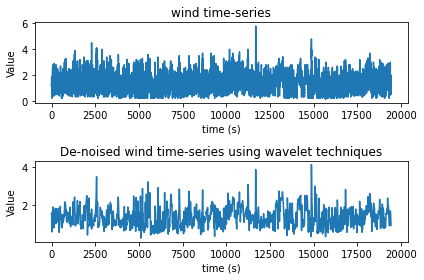

In [3]:
index = []
data = []
for i in range(len(wind)):
    X = float(i)
    Y = float(wind[i])
    index.append(X)
    data.append(Y)

# Create wavelet object and define parameters
w = pywt.Wavelet('sym8')  # 选用Daubechies8小波
maxlev = 4 #pywt.dwt_max_level(len(data), w.dec_len)
#print("maximum level is " + str(maxlev))
#threshold = 0.5  # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(data, 'sym8', level=maxlev)  # 将信号进行小波分解
for k in range(1, len(coeffs)):#len(coeffs)是小波系数的长度 = 5
    pingfang = coeffs[k]**2
    paixu = np.sort(pingfang)#把用来估计阈值的小波系数取绝对值，由小到大排列，然后将各元素平方，得到新的待估计向量
    N = len(paixu)
    R = []
    # Rigrsure阈值计算，无偏似然估计准则
    for i in range(N):
        j = i +1 
        Sum = np.sum(paixu[:j])
        fenmu = (N-2*j)+(N-j)*paixu[i]+Sum
        Risk = fenmu/N
        R.append(Risk)#风险向量的列表

    index1 = R.index(min(R))#找出列表中最小值的下标
    threshold = sqrt(paixu[index1])
    #print(threshold)
    coeffs[k] = pywt.threshold(coeffs[k], threshold*max(coeffs[k]))  # 将噪声滤波
    
datarec = pywt.waverec(coeffs, 'sym8')  # 将信号进行小波重构

mintime = 0
maxtime = mintime + len(data) + 1

#w = 95 / 10 / 2.54
#h = 115 / 10 / 2.54
#plt.figure(figsize=(w, h))
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(index[mintime:maxtime], data[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('Value')
plt.title("wind time-series")
plt.subplot(2, 1, 2)
plt.plot(index[mintime:maxtime], datarec[mintime:maxtime-1])
plt.xlabel('time (s)')
plt.ylabel('Value')
plt.title("De-noised wind time-series using wavelet techniques")

plt.tight_layout()
#plt.savefig( r'C:\Users\zzsgdsg7\Desktop\小波降噪结果-W.jpg',dpi = 600, pil_kwargs={'quality':95})
plt.show()

In [4]:
#小波降噪评价
'''信噪比:信噪比越大越好
        均方根误差:均方根误差越小越好，越小去噪效果越好
        :param org_signal:原始信号
        :param final_signal:降噪后的信号
        :return: 信噪比,均方根误差
        '''
def compute_snr(org_signal,fin_signal):
    clean = np.array(fin_signal)
    org_signal = np.array(org_signal)
    sigPower = sum(abs(clean)**2)/len(clean)#求出信号功率
    noisePower = sum(abs(org_signal-clean)**2)/len(org_signal - clean)#求出噪声功率
    SNR10 = 10* np.log10(sigPower/noisePower)
    return SNR10

'''计算均方根误差:均方根误差越小越好，越小去噪效果越好
        :param org_signal:原始信号
        :param final_signal:降噪后的信号
        :return: 均方根误差
'''
def compute_rmse(org_signal, final_signal):
    data = np.array(org_signal)
    final_signal = np.array(final_signal)
    rmse = np.sqrt(np.mean(np.square(data-final_signal)))
    return rmse


In [5]:
print(len(so2))
print(len(data))
print(len(datarec))
snr = compute_snr(data,datarec)
rmse = compute_rmse(data,datarec)
print('snr:{},rmse:{}'.format(snr,rmse))

19432
19432
19432
snr:10.22450349672092,rmse:0.4522481592081316


In [51]:
#验证结果
a = [5,5,6,4,5,6,7,8,9,10]
N= len(a)
R1 = []
# Rigrsure阈值计算，无偏似然估计准则
for i in range(N):
    j = i +1 
    Sum = np.sum(a[:j])
    fenmu = (N-2*j)+(N-j)*a[i]+Sum
    Risk1 = fenmu/N
    R1.append(Risk1)#风险向量的列表
print(R1)
index = R1.index(min(R1))#找出列表中最小值的下标
print(index)
thr = sqrt(a[index])
print(thr)

[5.8, 5.6, 6.2, 4.6, 5.0, 5.3, 5.5, 5.6, 5.6, 5.5]
3
2.0
